Data loaded successfully!
   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  
Dataset shape: (2919, 13)
Categorical Variables: 4
Integer Variables: 6
Float Variabl

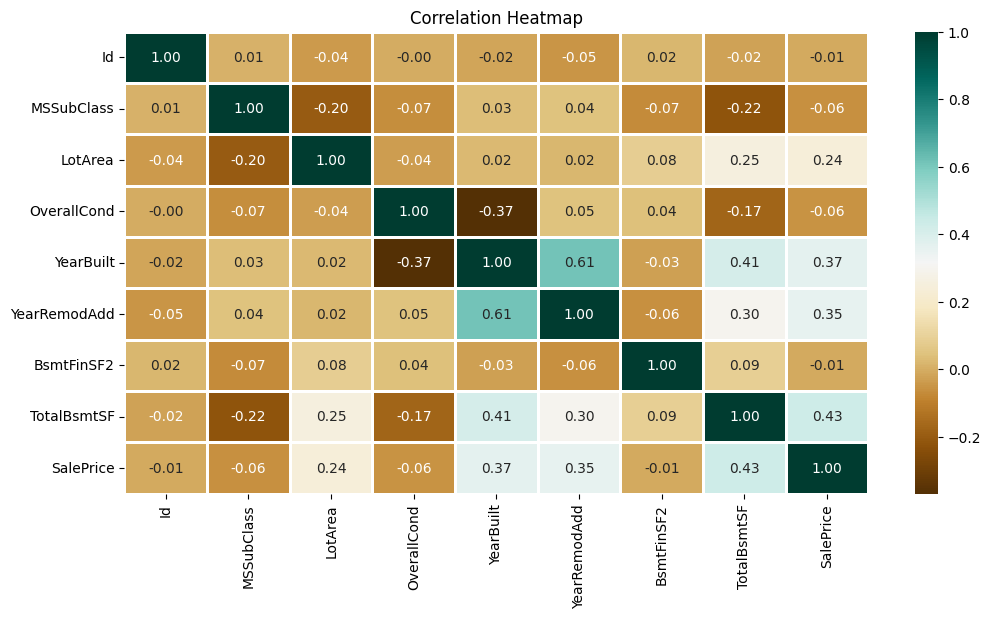

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

class HousePricePredictor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
        self.model = None

    def load_data(self):
        """Loads the dataset and handles exceptions."""
        try:
            self.dataset = pd.read_excel(self.file_path)
            print("Data loaded successfully!")
            print(self.dataset.head())  # Display the first few rows of the dataset
            print(f"Dataset shape: {self.dataset.shape}")  # Print the shape of the dataset
        except FileNotFoundError as e:
            print(f"Error: {e}")
        except Exception as e:
            print(f"An error occurred: {e}")

    def categorize_variables(self):
        """Categorizes variables into categorical, integer, and float types and counts them."""
        categorical_vars = self.dataset.select_dtypes(include=['object']).columns.tolist()
        integer_vars = self.dataset.select_dtypes(include=['int']).columns.tolist()
        float_vars = self.dataset.select_dtypes(include=['float']).columns.tolist()

        print("Categorical Variables:", len(categorical_vars))  # Count of categorical variables
        print("Integer Variables:", len(integer_vars))          # Count of integer variables
        print("Float Variables:", len(float_vars))              # Count of float variables

    def preprocess_data(self):
        """Performs preprocessing such as handling missing values and splitting data."""
        try:
            print("Columns in dataset:", self.dataset.columns)
            X = self.dataset.drop(['SalePrice'], axis=1)
            y = self.dataset['SalePrice']

            # Handle missing values for numerical columns
            X.fillna(X.mean(numeric_only=True), inplace=True)
            y.fillna(y.mean(), inplace=True)

            # Convert categorical columns to string if necessary
            categorical_cols = ['MSZoning', 'Exterior1st']
            for col in categorical_cols:
                X[col] = X[col].astype(str)

            # One-hot encoding for categorical features
            encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid dummy variable trap
            encoded_features = encoder.fit_transform(X[categorical_cols])
            encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

            # Combine with original DataFrame, dropping original categorical columns
            X = pd.concat([X.drop(categorical_cols, axis=1), encoded_df], axis=1)

            # Split the dataset into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print("Preprocessing completed!")
            print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

            # Reshape y_train and y_test to be 2D arrays
            y_train = y_train.values.reshape(-1, 1)  # Shape (2335, 1)
            y_test = y_test.values.reshape(-1, 1)    # Shape (584, 1)

            print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
            return X_train, X_test, y_train, y_test
        except KeyError as e:
            print(f"Error: {e} - Check if 'SalePrice' exists in the dataset.")
            return None, None, None, None  # Return None for unpacking to avoid errors
        except Exception as e:
            print(f"An error occurred during preprocessing: {e}")
            return None, None, None, None  # Return None for unpacking to avoid errors

    def train_model(self, X_train, y_train):
        """Trains a Random Forest model."""
        try:
            print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
            self.model = RandomForestRegressor(n_estimators=100, random_state=42)
            self.model.fit(X_train, y_train.ravel())  # Use ravel() to convert y_train to 1D for training
            print("Model trained successfully!")
        except Exception as e:
            print(f"An error occurred during training: {e}")

    def predict(self, X_test):
        """Makes predictions using the trained model."""
        try:
            if self.model:
                predictions = self.model.predict(X_test)
                print(f"First 5 predictions: {predictions[:5]}")  # Check some predictions
                return predictions
            else:
                print("Model not trained yet!")
        except Exception as e:
            print(f"An error occurred during prediction: {e}")

    def evaluate_model(self, predictions, y_test):
        """Evaluates the model using Mean Absolute Error."""
        try:
            print(f"True values: {y_test.flatten()[:5]}")  # Print first few true values
            print(f"Predicted values: {predictions[:5]}")  # Print first few predictions
            mae = mean_absolute_error(y_test, predictions)
            print(f"Mean Absolute Error: {mae}")
        except Exception as e:
            print(f"An error occurred during evaluation: {e}")

    def plot_correlation_heatmap(self):
        """Generates a heatmap of the correlation matrix for numerical features."""
        # Select only numerical features for correlation analysis
        numerical_dataset = self.dataset.select_dtypes(include=['number'])

        plt.figure(figsize=(12, 6))
        sns.heatmap(numerical_dataset.corr(),
                    cmap='BrBG',
                    fmt='.2f',
                    linewidths=2,
                    annot=True)
        plt.title("Correlation Heatmap")
        plt.show()

# Example usage:
predictor = HousePricePredictor('/content/HousePricePrediction.xlsx')  # Update with your file path
predictor.load_data()  # Load the dataset

# Categorize variables into categorical, integer, and float types and count them
predictor.categorize_variables()

X_train, X_test, y_train, y_test = predictor.preprocess_data()  # Preprocess the data

predictor.train_model(X_train, y_train)  # Train the model

predictions = predictor.predict(X_test)  # Make predictions

predictor.evaluate_model(predictions, y_test)  # Evaluate the model

# Plot the correlation heatmap
predictor.plot_correlation_heatmap()



Data loaded successfully!
   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  
Dataset shape: (2919, 13)


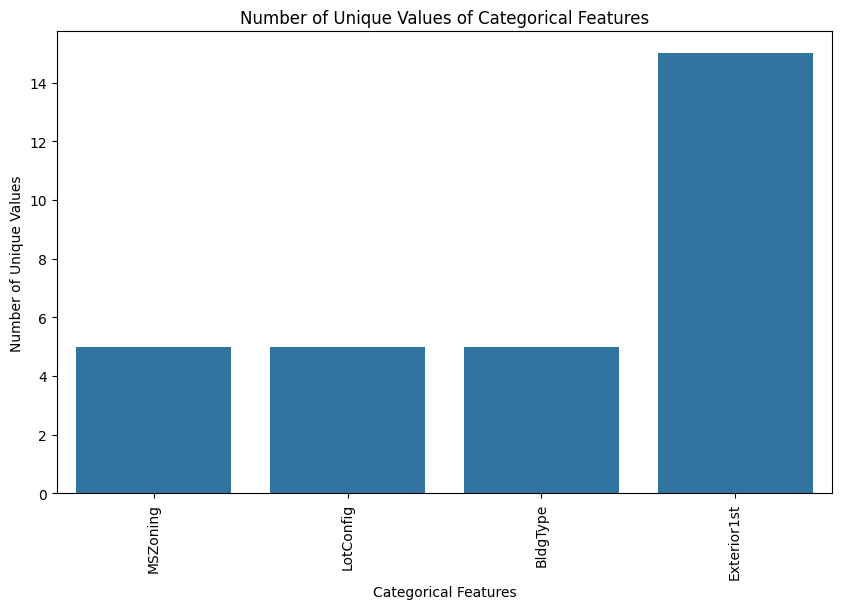

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

class HousePricePredictor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
        self.model = None

    def load_data(self):
        """Loads the dataset and handles exceptions."""
        try:
            self.dataset = pd.read_excel(self.file_path)
            print("Data loaded successfully!")
            print(self.dataset.head())  # Display the first few rows of the dataset
            print(f"Dataset shape: {self.dataset.shape}")  # Print the shape of the dataset
        except FileNotFoundError as e:
            print(f"Error: {e}")
        except Exception as e:
            print(f"An error occurred: {e}")

    def plot_unique_values(self):
        """Plots the number of unique values for categorical features."""
        # Select categorical columns
        object_cols = self.dataset.select_dtypes(include=['object']).columns.tolist()

        unique_values = [self.dataset[col].nunique() for col in object_cols]  # Get the number of unique values
        plt.figure(figsize=(10, 6))
        plt.title('Number of Unique Values of Categorical Features')
        plt.xticks(rotation=90)
        sns.barplot(x=object_cols, y=unique_values)
        plt.xlabel('Categorical Features')
        plt.ylabel('Number of Unique Values')
        plt.show()

    # Other methods remain the same...

# Example usage:
predictor = HousePricePredictor('/content/HousePricePrediction.xlsx')  # Update with your file path
predictor.load_data()  # Load the dataset

# Plot the number of unique values for categorical features
predictor.plot_unique_values()


Data loaded successfully!
   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  
Dataset shape: (2919, 13)


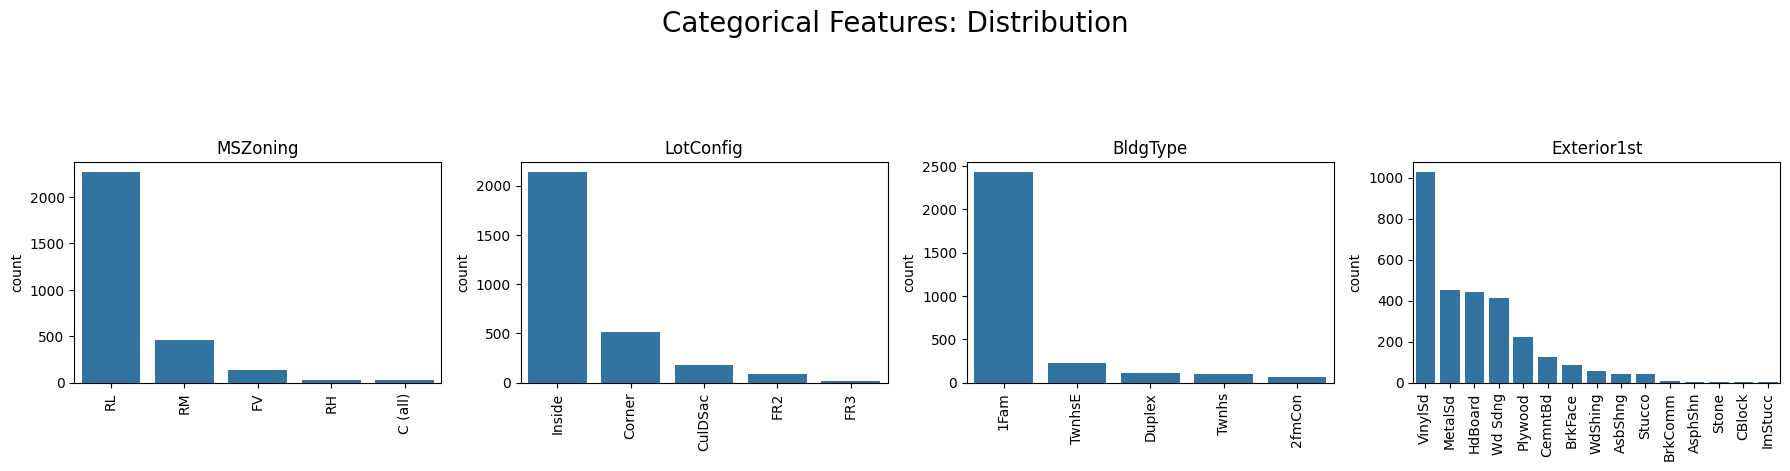

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

class HousePricePredictor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
        self.model = None

    def load_data(self):
        """Loads the dataset and handles exceptions."""
        try:
            self.dataset = pd.read_excel(self.file_path)
            print("Data loaded successfully!")
            print(self.dataset.head())  # Display the first few rows of the dataset
            print(f"Dataset shape: {self.dataset.shape}")  # Print the shape of the dataset
        except FileNotFoundError as e:
            print(f"Error: {e}")
        except Exception as e:
            print(f"An error occurred: {e}")

    def plot_categorical_distribution(self):
        """Plots the distribution of categorical features."""
        # Select categorical columns
        object_cols = self.dataset.select_dtypes(include=['object']).columns.tolist()

        plt.figure(figsize=(18, 36))
        plt.suptitle('Categorical Features: Distribution', fontsize=20)
        index = 1

        for col in object_cols:
            y = self.dataset[col].value_counts()
            plt.subplot(11, 4, index)  # Adjust the number of rows and columns as needed
            plt.xticks(rotation=90)
            sns.barplot(x=list(y.index), y=y)
            plt.title(col)  # Title for each subplot
            index += 1

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
        plt.show()

    # Other methods remain the same...

# Example usage:
predictor = HousePricePredictor('/content/HousePricePrediction.xlsx')  # Update with your file path
predictor.load_data()  # Load the dataset

# Plot the distribution of categorical features
predictor.plot_categorical_distribution()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder

class HousePricePredictor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
        self.model_rf = None
        self.model_svr = None

    def load_data(self):
        """Loads the dataset and handles exceptions."""
        try:
            self.dataset = pd.read_excel(self.file_path)
            print("Data loaded successfully!")
            print(self.dataset.head())  # Display the first few rows of the dataset to verify it's loaded correctly
        except FileNotFoundError as e:
            print(f"Error: {e}")
        except Exception as e:
            print(f"An error occurred: {e}")

    def preprocess_data(self):
        """Performs preprocessing such as handling missing values and splitting data."""
        try:
            print("Columns in dataset:", self.dataset.columns)
            X = self.dataset.drop(['SalePrice'], axis=1)
            y = self.dataset['SalePrice']

            # Drop rows where SalePrice is null
            combined = pd.concat([X, y], axis=1)
            combined.dropna(subset=['SalePrice'], inplace=True)

            # Split X and y again after dropping nulls
            X = combined.drop(['SalePrice'], axis=1)
            y = combined['SalePrice']

            # Identify categorical and numerical columns
            object_cols = X.select_dtypes(include=['object']).columns
            numerical_cols = X.select_dtypes(include=['number']).columns

            # One-hot encode categorical variables
            encoder = OneHotEncoder(sparse_output=False, drop='first')  # Change here
            encoded_features = encoder.fit_transform(X[object_cols])
            encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(object_cols))

            # Combine with original DataFrame and drop original categorical columns
            X = pd.concat([X.drop(object_cols, axis=1), encoded_df], axis=1)

            # Handle missing values in X
            X.fillna(X.mean(), inplace=True)

            # Split the dataset into training and validation sets
            X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
            y_train = y_train.values.reshape(-1, 1)  # Reshape y_train to 2D
            y_valid = y_valid.values.reshape(-1, 1)  # Reshape y_valid to 2D

            print("Preprocessing completed!")
            print(f"X_train shape: {X_train.shape}, X_valid shape: {X_valid.shape}")
            print(f"y_train shape: {y_train.shape}, y_valid shape: {y_valid.shape}")
            return X_train, X_valid, y_train, y_valid
        except KeyError as e:
            print(f"Error: {e} - Check if 'SalePrice' exists in the dataset.")
        except Exception as e:
            print(f"An error occurred during preprocessing: {e}")
            return None, None, None, None  # Ensure we return None if there's an error

    def train_rf_model(self, X_train, y_train):
        """Trains a Random Forest model."""
        try:
            print(f"Training Random Forest model with data shape: X_train={X_train.shape}, y_train={y_train.shape}")
            self.model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
            self.model_rf.fit(X_train, y_train.ravel())  # Use ravel to convert to 1D
            print("Random Forest model trained successfully!")
        except Exception as e:
            print(f"An error occurred during training: {e}")

    def train_svr_model(self, X_train, y_train):
        """Trains an SVR model."""
        try:
            print(f"Training SVR model with data shape: X_train={X_train.shape}, y_train={y_train.shape}")
            self.model_svr = SVR()
            self.model_svr.fit(X_train, y_train.ravel())  # Use ravel to convert to 1D
            print("SVR model trained successfully!")
        except Exception as e:
            print(f"An error occurred during training: {e}")

    def predict_rf(self, X_valid):
        """Makes predictions using the trained Random Forest model."""
        try:
            if self.model_rf:
                predictions = self.model_rf.predict(X_valid)
                print(f"First 5 Random Forest predictions: {predictions[:5]}")  # Check some predictions
                return predictions
            else:
                print("Random Forest model not trained yet!")
        except Exception as e:
            print(f"An error occurred during prediction: {e}")

    def predict_svr(self, X_valid):
        """Makes predictions using the trained SVR model."""
        try:
            if self.model_svr:
                predictions = self.model_svr.predict(X_valid)
                print(f"First 5 SVR predictions: {predictions[:5]}")  # Check some predictions
                return predictions
            else:
                print("SVR model not trained yet!")
        except Exception as e:
            print(f"An error occurred during prediction: {e}")

    def evaluate_model(self, y_valid, predictions):
        """Evaluates the model using Mean Absolute Percentage Error."""
        try:
            mape = mean_absolute_percentage_error(y_valid, predictions)
            return mape  # Return MAPE
        except Exception as e:
            print(f"An error occurred during evaluation: {e}")

# Example usage:
predictor = HousePricePredictor('/content/HousePricePrediction.xlsx')  # Update with your file path
predictor.load_data()  # Load the dataset

X_train, X_valid, y_train, y_valid = predictor.preprocess_data()  # Preprocess the data

if X_train is not None and X_valid is not None:  # Check if preprocessing was successful
    # Train models
    predictor.train_rf_model(X_train, y_train)  # Train Random Forest model
    predictor.train_svr_model(X_train, y_train)  # Train SVR model

    # Make predictions
    rf_predictions = predictor.predict_rf(X_valid)  # Random Forest predictions
    svr_predictions = predictor.predict_svr(X_valid)  # SVR predictions

    # Evaluate models
    rf_mape = predictor.evaluate_model(y_valid, rf_predictions)  # Evaluate Random Forest model
    svr_mape = predictor.evaluate_model(y_valid, svr_predictions)  # Evaluate SVR model

    # Print MAPE values
    print(f"Random Forest Mean Absolute Percentage Error: {rf_mape}")
    print(f"SVR Mean Absolute Percentage Error: {svr_mape}")


Data loaded successfully!
   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  
Columns in dataset: Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'LotConfig', 'B

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder

class HousePricePredictor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = pd.read_excel(file_path)  # Use read_excel for .xlsx files
        print("Data loaded successfully!")
        print(self.dataset.head())
        print("Columns in dataset:", self.dataset.columns)

    def preprocess_data(self):
        """Preprocess the data, including encoding categorical variables."""
        try:
            # Check data types and handle missing values more carefully
            for col in self.dataset.columns:
                if self.dataset[col].dtype == 'object':
                    # Fill missing categorical values with the mode
                    self.dataset[col] = self.dataset[col].fillna(self.dataset[col].mode()[0])
                else:
                    # Fill missing numeric values with the mean
                    self.dataset[col] = self.dataset[col].fillna(self.dataset[col].mean())

            # Ensure no mixed types in categorical columns
            categorical_cols = ['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
            for col in categorical_cols:
                self.dataset[col] = self.dataset[col].astype(str)

            # One-hot encoding for categorical variables (without sparse parameter)
            encoder = OneHotEncoder(drop='first')  # Removed sparse parameter
            encoded_features = encoder.fit_transform(self.dataset[categorical_cols])
            encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical_cols))
            self.dataset = pd.concat([self.dataset.drop(categorical_cols, axis=1), encoded_df], axis=1)

            # Split features and target variable
            X = self.dataset.drop(['SalePrice'], axis=1)
            y = self.dataset['SalePrice'].values.reshape(-1, 1)

            # Split the dataset into training and validation sets
            X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

            print("Preprocessing completed!")
            print(f"X_train shape: {X_train.shape}, X_valid shape: {X_valid.shape}")
            print(f"y_train shape: {y_train.shape}, y_valid shape: {y_valid.shape}")
            return X_train, X_valid, y_train, y_valid
        except Exception as e:
            print(f"An error occurred during preprocessing: {e}")
            return None, None, None, None

    def train_model(self, X_train, y_train):
        """Train both Random Forest and SVR models."""
        try:
            # Train Random Forest model
            rf_model = RandomForestRegressor(random_state=42)
            rf_model.fit(X_train, y_train.ravel())
            print("Random Forest model trained successfully!")

            # Train SVR model
            svr_model = SVR()
            svr_model.fit(X_train, y_train.ravel())
            print("SVR model trained successfully!")

            return rf_model, svr_model
        except Exception as e:
            print(f"An error occurred during model training: {e}")
            return None, None

    def evaluate_models(self, rf_model, svr_model, X_valid, y_valid):
        """Evaluate the trained models and print predictions and errors."""
        try:
            # Predictions
            rf_predictions = rf_model.predict(X_valid)
            svr_predictions = svr_model.predict(X_valid)

            print("First 5 Random Forest predictions:", rf_predictions[:5])
            print("First 5 SVR predictions:", svr_predictions[:5])

            # Calculate errors
            rf_mape = mean_absolute_percentage_error(y_valid, rf_predictions)
            svr_mape = mean_absolute_percentage_error(y_valid, svr_predictions)

            print("Random Forest Mean Absolute Percentage Error:", rf_mape)
            print("SVR Mean Absolute Percentage Error:", svr_mape)

            # Return the first prediction for both models
            return rf_predictions[0], svr_predictions[0]
        except Exception as e:
            print(f"An error occurred during model evaluation: {e}")
            return None, None

if __name__ == "__main__":
    # Replace 'your_file_path.xlsx' with the path to your dataset
    predictor = HousePricePredictor('/content/HousePricePrediction.xlsx')

    X_train, X_valid, y_train, y_valid = predictor.preprocess_data()  # Preprocess the data

    if X_train is not None and X_valid is not None:  # Check if preprocessing was successful
        rf_model, svr_model = predictor.train_model(X_train, y_train)  # Train the models

        if rf_model is not None and svr_model is not None:  # Ensure models were trained
            rf_first_pred, svr_first_pred = predictor.evaluate_models(rf_model, svr_model, X_valid, y_valid)
            print(f"First Random Forest Prediction: {rf_first_pred}")
            print(f"First SVR Prediction: {svr_first_pred}")


Data loaded successfully!
   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  
Columns in dataset: Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'LotConfig', 'B

In [ ]:
# Install the catboost package if you haven't already
!pip install catboost

# Import necessary libraries
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [ ]:
# Initialize the CatBoostRegressor model
cb_model = CatBoostRegressor()

# Fit the model on the training data
cb_model.fit(X_train, y_train)


Learning rate set to 0.046813
0:	learn: 53895.2722734	total: 50.4ms	remaining: 50.3s
1:	learn: 52553.4521361	total: 55.9ms	remaining: 27.9s
2:	learn: 51385.4185568	total: 61.9ms	remaining: 20.6s
3:	learn: 50079.6153069	total: 67.8ms	remaining: 16.9s
4:	learn: 48882.1647241	total: 73.6ms	remaining: 14.7s
5:	learn: 47839.4678220	total: 79.3ms	remaining: 13.1s
6:	learn: 46759.9814858	total: 86.9ms	remaining: 12.3s
7:	learn: 45911.7387715	total: 91.1ms	remaining: 11.3s
8:	learn: 45022.5740932	total: 97.2ms	remaining: 10.7s
9:	learn: 44213.3235304	total: 103ms	remaining: 10.2s
10:	learn: 43468.7015980	total: 116ms	remaining: 10.4s
11:	learn: 42694.7089971	total: 122ms	remaining: 10.1s
12:	learn: 41958.0190910	total: 129ms	remaining: 9.79s
13:	learn: 41232.7406586	total: 135ms	remaining: 9.48s
14:	learn: 40472.5874968	total: 140ms	remaining: 9.22s
15:	learn: 39716.9431442	total: 145ms	remaining: 8.93s
16:	learn: 39125.4870064	total: 149ms	remaining: 8.6s
17:	learn: 38514.2472154	total: 155ms

In [ ]:
# Make predictions on the validation set
preds = cb_model.predict(X_valid)


In [ ]:
# Calculate the R² score to evaluate model performance
cb_r2_score = r2_score(y_valid, preds)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor

class HousePricePredictor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = pd.read_excel(file_path)  # Use read_excel for .xlsx files
        print("Data loaded successfully!")
        print(self.dataset.head())
        print("Columns in dataset:", self.dataset.columns)

    def preprocess_data(self):
        """Preprocess the data, including encoding categorical variables."""
        try:
            # Check data types and handle missing values more carefully
            for col in self.dataset.columns:
                if self.dataset[col].dtype == 'object':
                    # Fill missing categorical values with the mode
                    self.dataset[col] = self.dataset[col].fillna(self.dataset[col].mode()[0])
                else:
                    # Fill missing numeric values with the mean
                    self.dataset[col] = self.dataset[col].fillna(self.dataset[col].mean())

            # Ensure no mixed types in categorical columns
            categorical_cols = ['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
            for col in categorical_cols:
                self.dataset[col] = self.dataset[col].astype(str)

            # One-hot encoding for categorical variables (without sparse parameter)
            encoder = OneHotEncoder(drop='first')  # Removed sparse parameter
            encoded_features = encoder.fit_transform(self.dataset[categorical_cols])
            encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical_cols))
            self.dataset = pd.concat([self.dataset.drop(categorical_cols, axis=1), encoded_df], axis=1)

            # Split features and target variable
            X = self.dataset.drop(['SalePrice'], axis=1)
            y = self.dataset['SalePrice'].values.reshape(-1, 1)

            # Split the dataset into training and validation sets
            X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

            print("Preprocessing completed!")
            print(f"X_train shape: {X_train.shape}, X_valid shape: {X_valid.shape}")
            print(f"y_train shape: {y_train.shape}, y_valid shape: {y_valid.shape}")
            return X_train, X_valid, y_train, y_valid
        except Exception as e:
            print(f"An error occurred during preprocessing: {e}")
            return None, None, None, None

    def train_models(self, X_train, y_train):
        """Train Random Forest, SVR, and CatBoost models."""
        try:
            # Train Random Forest model
            rf_model = RandomForestRegressor(random_state=42)
            rf_model.fit(X_train, y_train.ravel())
            print("Random Forest model trained successfully!")

            # Train SVR model
            svr_model = SVR()
            svr_model.fit(X_train, y_train.ravel())
            print("SVR model trained successfully!")

            # Train CatBoost model
            cb_model = CatBoostRegressor(silent=True)  # Set silent=True to suppress output during training
            cb_model.fit(X_train, y_train)
            print("CatBoost model trained successfully!")

            return rf_model, svr_model, cb_model
        except Exception as e:
            print(f"An error occurred during model training: {e}")
            return None, None, None

    def evaluate_models(self, rf_model, svr_model, cb_model, X_valid, y_valid):
        """Evaluate the trained models and print predictions and errors."""
        try:
            # Predictions
            rf_predictions = rf_model.predict(X_valid)
            svr_predictions = svr_model.predict(X_valid)
            cb_predictions = cb_model.predict(X_valid)

            print("First 5 Random Forest predictions:", rf_predictions[:5])
            print("First 5 SVR predictions:", svr_predictions[:5])
            print("First 5 CatBoost predictions:", cb_predictions[:5])

            # Calculate errors
            rf_mape = mean_absolute_percentage_error(y_valid, rf_predictions)
            svr_mape = mean_absolute_percentage_error(y_valid, svr_predictions)
            cb_mape = mean_absolute_percentage_error(y_valid, cb_predictions)

            rf_r2_score = r2_score(y_valid, rf_predictions)
            svr_r2_score = r2_score(y_valid, svr_predictions)
            cb_r2_score = r2_score(y_valid, cb_predictions)

            print("Random Forest Mean Absolute Percentage Error:", rf_mape)
            print("SVR Mean Absolute Percentage Error:", svr_mape)
            print("CatBoost Mean Absolute Percentage Error:", cb_mape)

            print("Random Forest R² Score:", rf_r2_score)
            print("SVR R² Score:", svr_r2_score)
            print("CatBoost R² Score:", cb_r2_score)

            # Return the first prediction for all models
            return rf_predictions[0], svr_predictions[0], cb_predictions[0]
        except Exception as e:
            print(f"An error occurred during model evaluation: {e}")
            return None, None, None

if __name__ == "__main__":
    # Replace 'your_file_path.xlsx' with the path to your dataset
    predictor = HousePricePredictor('/content/HousePricePrediction.xlsx')

    X_train, X_valid, y_train, y_valid = predictor.preprocess_data()  # Preprocess the data

    if X_train is not None and X_valid is not None:  # Check if preprocessing was successful
        rf_model, svr_model, cb_model = predictor.train_models(X_train, y_train)  # Train the models

        if rf_model is not None and svr_model is not None and cb_model is not None:  # Ensure models were trained
            rf_first_pred, svr_first_pred, cb_first_pred = predictor.evaluate_models(rf_model, svr_model, cb_model, X_valid, y_valid)
            print(f"First Random Forest Prediction: {rf_first_pred}")
            print(f"First SVR Prediction: {svr_first_pred}")
            print(f"First CatBoost Prediction: {cb_first_pred}")


Data loaded successfully!
   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  
Columns in dataset: Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'LotConfig', 'B

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor

class HousePricePredictor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None

    def load_data(self):
        # Load the dataset
        self.dataset = pd.read_excel(self.file_path)
        print("Data loaded successfully!")
        print(self.dataset.head())

    def preprocess_data(self):
        # Preprocess the data (e.g., handle missing values, encode categorical features)
        X = self.dataset.drop(columns=['SalePrice'])
        y = self.dataset['SalePrice']  # Target variable

        # Check for and handle missing values in the target variable
        if y.isnull().any():
            print("Found NaN values in the target variable 'SalePrice'. Dropping those rows.")
            self.dataset = self.dataset.dropna(subset=['SalePrice'])  # Drop rows where 'SalePrice' is NaN
            y = self.dataset['SalePrice']  # Update y after dropping rows
            X = self.dataset.drop(columns=['SalePrice'])  # Update X as well

        # Impute missing values for numerical features
        num_cols = X.select_dtypes(include=['int64', 'float64']).columns
        num_imputer = SimpleImputer(strategy='mean')
        X[num_cols] = num_imputer.fit_transform(X[num_cols])

        # Impute missing values for categorical features
        cat_cols = X.select_dtypes(include=['object']).columns
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

        # Encoding categorical features
        encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
        X_encoded = encoder.fit_transform(X[cat_cols])

        # Create a DataFrame for the encoded features and concatenate it with the rest
        X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cat_cols))
        X = pd.concat([X.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)
        X.drop(columns=cat_cols, inplace=True)

        # Split the data into training and validation sets
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

        return X_train, X_valid, y_train, y_valid

    def train_and_evaluate(self):
        X_train, X_valid, y_train, y_valid = self.preprocess_data()

        # Initialize models
        rf_model = RandomForestRegressor()
        svr_model = SVR()
        cb_model = CatBoostRegressor(silent=True)

        # Train models
        rf_model.fit(X_train, y_train)
        svr_model.fit(X_train, y_train)
        cb_model.fit(X_train, y_train)

        # Make predictions
        rf_preds = rf_model.predict(X_valid)
        svr_preds = svr_model.predict(X_valid)
        cb_preds = cb_model.predict(X_valid)

        # Calculate MAPE for each model
        rf_mape = mean_absolute_percentage_error(y_valid, rf_preds)
        svr_mape = mean_absolute_percentage_error(y_valid, svr_preds)
        cb_mape = mean_absolute_percentage_error(y_valid, cb_preds)

        # Print the results in the specified format
        print(f"SVR MAPE: {svr_mape:.10f}")
        print(f"Random Forest MAPE: {rf_mape:.10f}")
        print(f"CatBoost MAPE: {cb_mape:.10f}")

if __name__ == "__main__":
    predictor = HousePricePredictor('/content/HousePricePrediction.xlsx')  # Replace with your file path
    predictor.load_data()
    predictor.train_and_evaluate()



Data loaded successfully!
   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  
Found NaN values in the target variable 'SalePrice'. Dropping those rows.
SVR MAPE: 0